In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage import img_as_ubyte, feature
import os
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split

class Preprocessor:
    def __init__(self):
        # self.image_size = image_size
        pass

    def extract_features(self,image):
        """
        @brief This method extracts Haralick texture features and Histogram of Oriented Gradients (HOG) features from an image.
        @details The input image is first converted to grayscale, as the feature extraction methods require 2D grayscale images.
        The grayscale image is then rescaled from a float range (0.0 - 1.0 by default) to uint8 range (0-255).
        The Gray-Level Co-Occurrence Matrix (GLCM) of the grayscale image is computed, and Haralick texture features are extracted from the GLCM.
        HOG features are then computed from the grayscale image. Finally, the Haralick and HOG features are combined into a single feature vector.
        @param image The input image from which features are to be extracted.
        @return A numpy array containing the combined Haralick and HOG feature vector.
        """
        
        # Convert the RGB image to grayscale as the feature extraction methods require 2D grayscale images
        image_gray = rgb2gray(image)

        # Rescale the grayscale image from a float range (0.0 - 1.0 by default) to uint8 range (0-255)
        image_gray = img_as_ubyte(image_gray)

        # Compute the Gray-Level Co-Occurrence Matrix (GLCM) of the grayscale image
        glcm = graycomatrix(image_gray, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
        
        # Compute Haralick texture features from the GLCM
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        energy = graycoprops(glcm, 'energy')[0, 0]
        correlation = graycoprops(glcm, 'correlation')[0, 0]
        
        # Combine all Haralick features into a single numpy array
        haralick_features = np.array([contrast, dissimilarity, homogeneity, energy, correlation])

        # Compute the Histogram of Oriented Gradients (HOG) features of the grayscale image
        hog_features = feature.hog(image_gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys')

        # Combine the Haralick and HOG features into a single feature vector
        features = np.concatenate((haralick_features, hog_features))

        # Return the combined feature vector
        return features
        
    def load_images_from_folder(self,folder_name, categories, image_size=(150, 150, 3)):
        """
        Load images from a specified folder, resize them to the same size, and flatten them.
        
        Args:
        folder_name (str): The folder in which the images are stored.
        categories (list of str): The categories of images.
        image_size (tuple): The size to which to resize the images.

        Returns:
        flat_data_arr (list): The list of flattened, resized images.
        target_arr (list): The list of target categories for each image.
        """
        flat_data_arr = []
        target_arr = []
        for i, category in enumerate(categories):
            print(f'Loading... category: {category}')
            category_path = os.path.join(folder_name, category)
            
            if not os.path.isdir(category_path):
                print(f'Category path {category_path} not found')
                continue

            for img_file in os.listdir(category_path):
                img_file_path = os.path.join(category_path, img_file)
                
                try:
                    img_array = imread(img_file_path)
                    img_resized = resize(img_array, image_size)
                    features = self.extract_features(img_resized)
                    flat_data_arr.append(features)
                    target_arr.append(i)
                except Exception as e:
                    if (".DS_Store" in img_file_path):
                        continue
                    print(f'Error occurred while processing file {img_file_path}. Error message: {e}')
                    continue

            print(f'Loaded category: {category} successfully')
        
        return flat_data_arr, target_arr , img_resized

    def preprocess(self, dataset='dataset_18',categories=['covid','normal']):
        # Usage:
        flat_data, target, img_resized = self.load_images_from_folder(dataset, categories)
        flat_data = np.array(flat_data)
        target = np.array(target)
        return flat_data,target


In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import xgboost as xgb
from bayes_opt import BayesianOptimization
import joblib
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import numpy as np

class Classifier:
    """
    @brief Class representing a binary classifier with a XGBoost model.
    @param validation (tuple): A tuple of validation datasets to be used for early stopping in XGBoost training.
    """

    def __init__(self, validation):
        """
        @brief Constructor method. Initializes main attributes.
        """
        self.model = None
        self.pipeline = None
        self.best_params = None
        self.validation = validation

    def custom_cross_val(self, pipeline, X, y, n_splits=5, random_state=1):
        """
        @brief Performs cross validation given a pipeline, features and targets.
        @param pipeline: scikit-learn Pipeline object
        @param X: numpy array or pandas DataFrame with features
        @param y: numpy array or pandas Series with targets
        @param n_splits: number of cross-validation folds
        @param random_state: random seed for reproducibility
        @return The mean of accuracy scores across all folds.
        """

        # Define the cross-validator (here, we use n_splits-fold CV)
        kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
        # This will hold the cross-validation scores
        cv_scores = []
        # Perform the cross-validation manually
        for train_index, val_index in kf.split(X):
            cv_X_train, cv_X_val = X[train_index], X[val_index]
            cv_y_train, cv_y_val = y[train_index], y[val_index]
            if(self.model_type == "xgb"):
                pipeline.fit(cv_X_train, cv_y_train,
                            classifier__eval_set=[(cv_X_val, cv_y_val)],
                            classifier__early_stopping_rounds=5, classifier__verbose=False)
            else:
                pipeline.fit(cv_X_train, cv_y_train)
            y_pred = pipeline.predict(cv_X_val)
            cv_scores.append(accuracy_score(cv_y_val, y_pred))
        return np.mean(cv_scores)

    def svm_func(self, C, gamma, X_train, y_train):
        """
        Trains an SVM model with given hyperparameters and returns cross-validation score.

        Params:
        C: Penalty parameter C of the error term.
        gamma: Kernel coefficient.
        X_train: training features
        y_train: training target

        Returns: Cross-validation score.
        """
        model = SVC(C=C, gamma=gamma, probability=True)
        pipeline = Pipeline([('scaler', StandardScaler()),
                             ('classifier', model)])
        score = self.custom_cross_val(pipeline, X_train, y_train)
        return score

    def rf_func(self, n_estimators, max_depth, max_features, X_train, y_train):
        """
        Trains a Random Forest model with given hyperparameters and returns cross-validation score.

        Params:
        n_estimators: The number of trees in the forest.
        max_depth: The maximum depth of the tree.
        max_features : The number of features to consider when looking for the best split
        X_train: training features
        y_train: training target

        Returns: Cross-validation score.
        """
        model = RandomForestClassifier(n_estimators=int(n_estimators),
                                       max_depth=int(max_depth),
                                       max_features=max_features,
                                       random_state=1)
        pipeline = Pipeline([('scaler', StandardScaler()),
                             ('classifier', model)])
        score = self.custom_cross_val(pipeline, X_train, y_train)
        return score

    def xgb_func(self, n_estimators, learning_rate, max_depth, subsample, colsample_bytree, gamma, X_train, y_train):
        """
        @brief Trains a XGBoost model with given hyperparameters and returns cross-validation score.

        @param n_estimators: number of boosted trees to fit
        @param learning_rate: boosting learning rate
        @param max_depth: maximum depth of a tree
        @param subsample: subsample ratio of the training instances
        @param colsample: subsample ratio of columns when constructing each tree
        @param gamma: minimum loss reduction required to make a split
        @param X_train: training features
        @param y_train: training target
        @return Cross-validation score.
        """
        n_estimators = int(n_estimators)
        max_depth = int(max_depth)
        model = xgb.XGBClassifier(n_estimators=n_estimators,
                                  learning_rate=learning_rate,
                                  max_depth=max_depth,
                                  subsample=subsample,
                                  colsample_bytree=colsample_bytree,
                                  gamma=gamma,
                                  eval_metric='logloss',
                                  objective='binary:logistic',
                                  tree_method='gpu_hist', gpu_id=0)

        pipeline = Pipeline([('scaler', StandardScaler()),
                            ('classifier', model)])
        score = self.custom_cross_val(pipeline, X_train, y_train)

        return score

    def optimize(self, X_train, y_train, model_type='xgb'):
        """
        Uses Bayesian optimization to find the best hyperparameters for the model.

        Params:
        X_train: training features
        y_train: training target
        model_type: The type of model to use. Can be 'xgb', 'svm', or 'rf'.
        """
        self.model_type = model_type
        if model_type == 'xgb':
            pbounds = {'learning_rate': (0.01, 0.2),
                       'n_estimators': (100, 1000),
                       'max_depth': (3, 7),
                       'subsample': (0.3, 0.7),
                       'colsample_bytree': (0.1, 0.5),
                       'gamma': (0, 5)}

            optimizer = BayesianOptimization(
                f=lambda n_estimators, learning_rate, max_depth, subsample, colsample_bytree, gamma: self.xgb_func(
                    n_estimators, learning_rate, max_depth, subsample, colsample_bytree, gamma, X_train, y_train),
                pbounds=pbounds,
                random_state=1,
            )

        elif model_type == 'svm':
            pbounds = {'C': (0.1, 100),
                       'gamma': (0.0001, 1)}

            optimizer = BayesianOptimization(
                f=lambda C, gamma: self.svm_func(
                    C, gamma, X_train, y_train),
                pbounds=pbounds,
                random_state=1,
            )

        elif model_type == 'rf':
            pbounds = {'n_estimators': (100, 1000),
                       'max_depth': (3, 7),
                       'max_features': (0.1, 0.5)}

            optimizer = BayesianOptimization(
                f=lambda n_estimators, max_depth, max_features: self.rf_func(
                    n_estimators, max_depth, max_features, X_train, y_train),
                pbounds=pbounds,
                random_state=1,
            )

        optimizer.maximize(init_points=3, n_iter=2)
        self.best_params = optimizer.max['params']

    def train(self, X_train, y_train, model_type='xgb'):
        """
        Train the model with the best hyperparameters.

        Params:
        X_train: training features
        y_train: training target
        model_type: The type of model to use. Can be 'xgb', 'svm', or 'rf'.

        Returns: Evaluated results of the model
        """
        if model_type == 'xgb':
            self.best_params['n_estimators'] = int(self.best_params['n_estimators'])
            self.best_params['max_depth'] = int(self.best_params['max_depth'])
            self.pipeline = Pipeline([('scaler', StandardScaler()),
                                    ('classifier', xgb.XGBClassifier(**self.best_params,
                                                                    eval_metric='logloss',
                                                                    objective='binary:logistic',
                                                                    tree_method='gpu_hist', gpu_id=0))])
            self.pipeline.fit(X_train, y_train,
                          classifier__eval_set=self.validation)
            return self.pipeline.named_steps['classifier'].evals_result()
        elif model_type == 'svm':
            self.pipeline = Pipeline([('scaler', StandardScaler()),
                                    ('classifier', SVC(**self.best_params,probability=True))])

        elif model_type == 'rf':
            self.best_params['n_estimators'] = int(self.best_params['n_estimators'])
            self.best_params['max_depth'] = int(self.best_params['max_depth'])
            self.pipeline = Pipeline([('scaler', StandardScaler()),
                                    ('classifier', RandomForestClassifier(**self.best_params))])

        self.pipeline.fit(X_train, y_train)
        return None

    def predict(self, X):
        """
        @brief Predicts target with the trained model.
        @param X: numpy array or pandas DataFrame with features
        @return Predicted target values.
        """
        return self.pipeline.predict(X)

    def save_model(self, file_path):
        """
        @brief Saves the trained model to a file.
        @param file_path: path to the output file
        """
        if self.pipeline is not None:
            joblib.dump(self.pipeline, file_path)
        else:
            print("Cannot save an uninitialized model. Please train the model first.")

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,classification_report
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread
import os

class Evaluator:
    """
    @brief Class for evaluating a classifier model and making predictions.
    @param model: The classifier model to evaluate
    @param preprocessor: The preprocessor used for the model
    """

    def __init__(self, model, preprocessor):
        """
        @brief Constructor method. Initializes main attributes.
        @param model: Trained model for evaluation.
        @param preprocessor: Preprocessor for data preparation.
        """
        self.model = model
        self.preprocessor = preprocessor

    def evaluate(self, X_test, y_test):
        """
        @brief Evaluates the model using a test set and calculates evaluation metrics.
        @param X_test: Test features.
        @param y_test: True target values.
        @return A report containing the evaluation metrics.
        """
        y_pred = self.model.predict(X_test)
        report = self.calculate_metrics(y_test, y_pred)
        return report

    def plot_log_loss(self, evals_result):
        """
        @brief Plots the log loss curve of the model during its training.
        @param evals_result: Dictionary containing the evaluation results.
        """
        epochs = len(evals_result['validation_0']['logloss'])
        x_axis = range(0, epochs)

        fig, ax = plt.subplots()
        ax.plot(x_axis, evals_result['validation_0']['logloss'], label='Train')
        ax.plot(x_axis, evals_result['validation_1']['logloss'], label='Validation')
        ax.legend()
        plt.ylabel('Log Loss')
        plt.title('XGBoost Log Loss')
        plt.show()

    def predict_images_in_dir(self, directory, Categories):
        """
        @brief Makes predictions for all images in a directory.
        @param directory: The directory path containing the images.
        @param Categories: The categories that the images can belong to.
        """
        for image_name in os.listdir(directory):
            if image_name.endswith(".jpg") or image_name.endswith(".png"):
                print(f"Image Name: {image_name}")
                image_path = os.path.join(directory, image_name)
                img = imread(image_path)
                plt.imshow(img)
                plt.show()

                img_resized = resize(img, (150, 150, 3))
                features = self.preprocessor.extract_features(img_resized)
                l=[features]

                probability = self.model.predict_proba(l)
                for ind, val in enumerate(Categories):
                    print(f'{val} = {probability[0][ind]*100}%')

                print("The predicted image is : " + Categories[self.model.predict(l)[0]])
                print("\n")
            else:
                print(f"Ignored {image_name}")

    def calculate_metrics(self, y_test, y_pred):
        """
        @brief Calculates and prints several evaluation metrics.
        @param y_test: True target values.
        @param y_pred: Predicted target values.
        @return A dictionary containing the evaluation metrics.
        """
        accuracy = accuracy_score(y_test, y_pred)*100
        precision = precision_score(y_test, y_pred, average='weighted')*100
        recall = recall_score(y_test, y_pred, average='weighted')*100
        f1 = f1_score(y_test, y_pred, average='weighted')*100
        auc_roc = roc_auc_score(y_test, y_pred)*100
        print(classification_report(y_test,y_pred))
        print(f"Accuracy: {accuracy}%\nPrecision: {precision}%\nRecall: {recall}%\nF1 Score: {f1}%\nAUC-ROC: {auc_roc}%")


In [5]:
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import joblib

class Inference:
    def __init__(self, model_path, preprocessor):
        # Load the trained model from the provided path
        self.model = joblib.load(model_path)
        self.preprocessor = preprocessor

    def preprocess_input(self, input_data):
        # Preprocess the input data in the same manner as was done during training.
        # converting it to grayscale, etc.
        # Here, we assume `input_data` is an image path.
        img = imread(input_data)
        img_resized = resize(img, (150, 150, 3))
        features = self.preprocessor.extract_features(img_resized)
        return np.array([features])

    def predict(self, input_data):
        # Make a prediction using the trained model and the preprocessed input data
        preprocessed_data = self.preprocess_input(input_data)
        prediction = self.model.predict(preprocessed_data)
        return prediction


In [6]:
# Initialize the classes
preprocessor = Preprocessor()

# Load the images and labels
X, y = preprocessor.preprocess('./dataset_18')

Loading... category: covid
Loaded category: covid successfully
Loading... category: normal
Loaded category: normal successfully


In [7]:
# Splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=1,
                                                    stratify=y)

x_test, x_val, y_test, y_val = train_test_split(
    x_test, y_test, test_size=0.5, random_state=1, stratify=y_test)

In [8]:
clf = Classifier(validation=[(x_train, y_train), (x_val, y_val)])
# Optimize the hyperparameters
clf.optimize(x_train, y_train,"xgb")

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.696     | 0.2668    | 3.602     | 0.01002   | 4.209     | 232.1     | 0.3369    |
| 2         | 0.703     | 0.1745    | 1.728     | 0.08539   | 5.155     | 477.3     | 0.5741    |
| 3         | 0.7328    | 0.1818    | 4.391     | 0.0152    | 5.682     | 475.6     | 0.5235    |
| 4         | 0.6822    | 0.4849    | 4.457     | 0.179     | 5.296     | 475.7     | 0.5276    |
| 5         | 0.7164    | 0.3391    | 1.592     | 0.136     | 4.794     | 255.0     | 0.4212    |


In [9]:
# Train the classifier with the optimized hyperparameters
history = clf.train(x_train, y_train,"xgb")
clf.save_model("./mlModels/xgbModel.joblib")

[0]	validation_0-logloss:0.69093	validation_1-logloss:0.69056
[1]	validation_0-logloss:0.68832	validation_1-logloss:0.68665
[2]	validation_0-logloss:0.69014	validation_1-logloss:0.68879
[3]	validation_0-logloss:0.68813	validation_1-logloss:0.68642
[4]	validation_0-logloss:0.68644	validation_1-logloss:0.68442
[5]	validation_0-logloss:0.68808	validation_1-logloss:0.68636
[6]	validation_0-logloss:0.68949	validation_1-logloss:0.68945
[7]	validation_0-logloss:0.69041	validation_1-logloss:0.68930
[8]	validation_0-logloss:0.68816	validation_1-logloss:0.68676
[9]	validation_0-logloss:0.68972	validation_1-logloss:0.68873
[10]	validation_0-logloss:0.68768	validation_1-logloss:0.68641
[11]	validation_0-logloss:0.68972	validation_1-logloss:0.68874
[12]	validation_0-logloss:0.68771	validation_1-logloss:0.68644
[13]	validation_0-logloss:0.68579	validation_1-logloss:0.68424
[14]	validation_0-logloss:0.68769	validation_1-logloss:0.68643
[15]	validation_0-logloss:0.68590	validation_1-logloss:0.68436
[1

              precision    recall  f1-score   support

           0       0.86      0.70      0.78        27
           1       0.81      0.92      0.86        37

    accuracy                           0.83        64
   macro avg       0.84      0.81      0.82        64
weighted avg       0.83      0.83      0.82        64

Accuracy: 82.8125%
Precision: 83.23525432900433%
Recall: 82.8125%
F1 Score: 82.47949496254196%
AUC-ROC: 81.13113113113114%


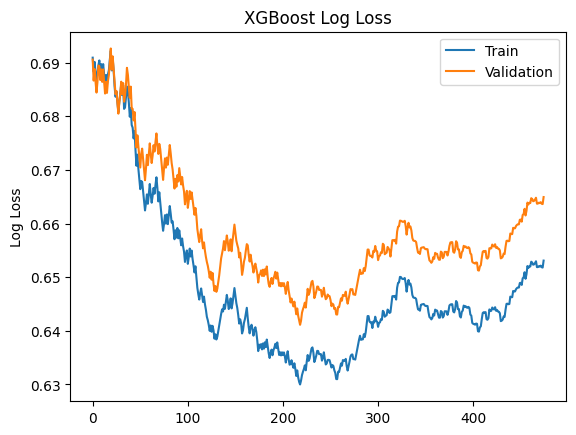

Image Name: Normal-375.png


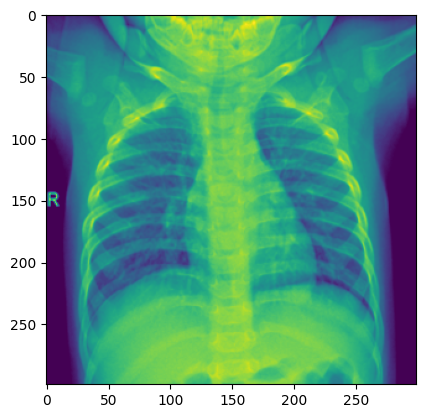

covid = 8.557015657424927%
normal = 91.44298434257507%
The predicted image is : normal


Image Name: COVID-443.png


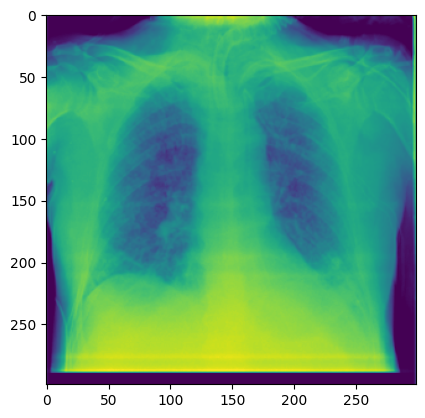

covid = 44.83419060707092%
normal = 55.16580939292908%
The predicted image is : normal


Image Name: Normal-354.png


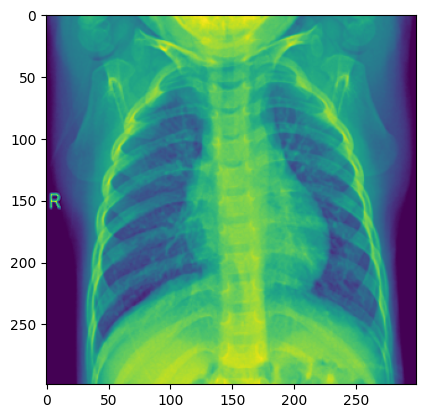

covid = 3.8111984729766846%
normal = 96.18880152702332%
The predicted image is : normal


Image Name: COVID-484.png


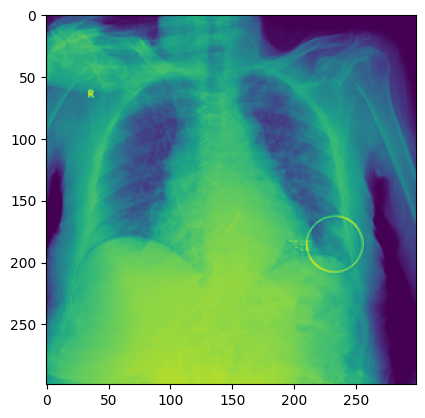

covid = 89.93508815765381%
normal = 10.064911842346191%
The predicted image is : covid


Ignored .DS_Store
Image Name: COVID-415.png


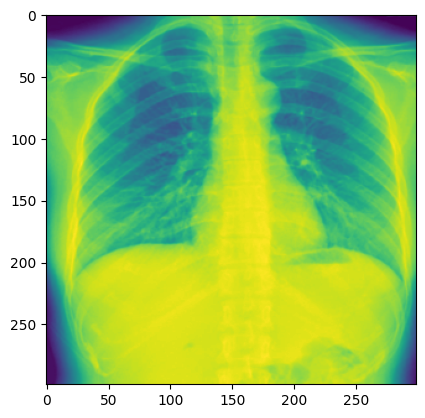

covid = 64.64850902557373%
normal = 35.35149395465851%
The predicted image is : covid


Image Name: Normal-332.png


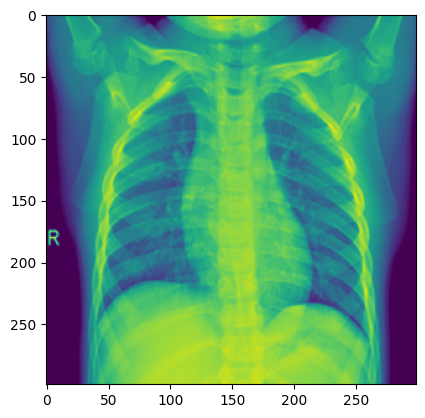

covid = 6.206619739532471%
normal = 93.79338026046753%
The predicted image is : normal




In [10]:
evaluator = Evaluator(model=clf.pipeline, preprocessor=preprocessor)
# Evaluate the model
evaluator.evaluate(x_test, y_test)
evaluator.plot_log_loss(history)
# Predict the images in a directory
evaluator.predict_images_in_dir("dataset_18/testing", ['covid', 'normal'])

|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------
| 1         | 0.581     | 41.76     | 0.7204    |
| 2         | 0.581     | 0.1114    | 0.3024    |
| 3         | 0.581     | 14.76     | 0.09243   |
| 4         | 0.581     | 99.99     | 0.1198    |
| 5         | 0.581     | 99.98     | 0.7918    |
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.58      1.00      0.73        37

    accuracy                           0.58        64
   macro avg       0.29      0.50      0.37        64
weighted avg       0.33      0.58      0.42        64

Accuracy: 57.8125%
Precision: 33.4228515625%
Recall: 57.8125%
F1 Score: 42.35767326732673%
AUC-ROC: 50.0%
Image Name: Normal-375.png


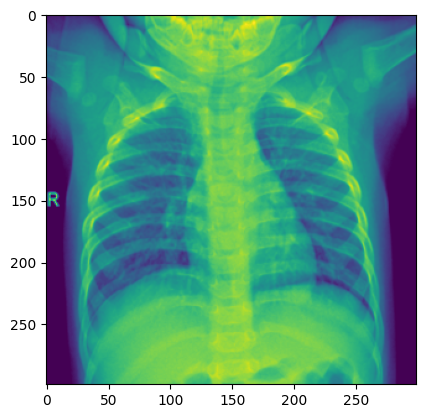

covid = 41.58763959125898%
normal = 58.41236040874104%
The predicted image is : normal


Image Name: COVID-443.png


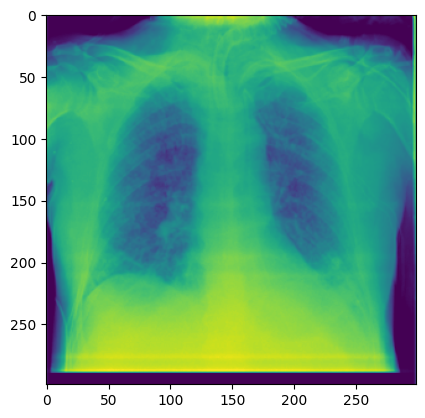

covid = 41.58763959125898%
normal = 58.41236040874104%
The predicted image is : normal


Image Name: Normal-354.png


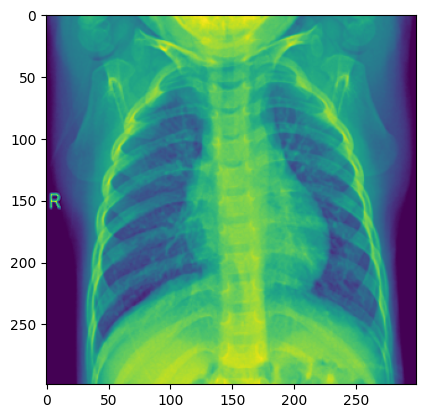

covid = 41.58763959125898%
normal = 58.41236040874104%
The predicted image is : normal


Image Name: COVID-484.png


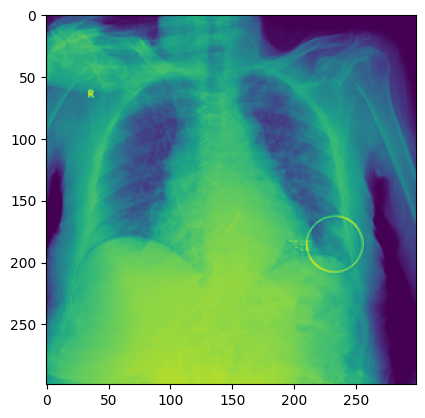

covid = 41.58763959125898%
normal = 58.41236040874104%
The predicted image is : normal


Ignored .DS_Store
Image Name: COVID-415.png


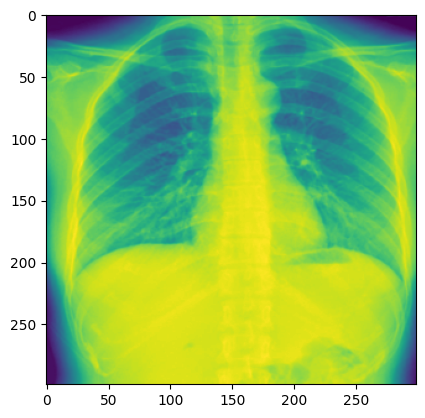

covid = 41.58763959125898%
normal = 58.41236040874104%
The predicted image is : normal


Image Name: Normal-332.png


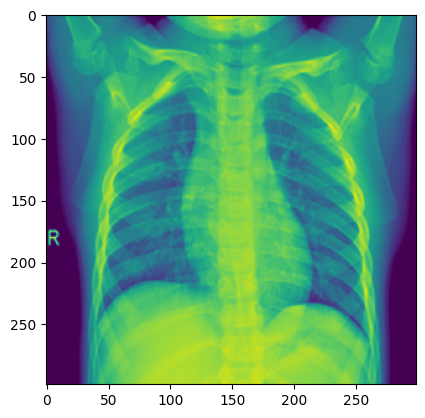

covid = 41.58763959125898%
normal = 58.41236040874104%
The predicted image is : normal




In [13]:
clf = Classifier(validation=[(x_train, y_train), (x_val, y_val)])
clf.optimize(x_train, y_train,"svm")
history = clf.train(x_train, y_train,"svm")
clf.save_model("./mlModels/svmModel.joblib")
evaluator = Evaluator(model=clf.pipeline, preprocessor=preprocessor)
# Evaluate the model
evaluator.evaluate(x_test, y_test)
# Predict the images in a directory
evaluator.predict_images_in_dir("dataset_18/testing", ['covid', 'normal'])

|   iter    |  target   | max_depth | max_fe... | n_esti... |
-------------------------------------------------------------
| 1         | 0.7769    | 4.668     | 0.3881    | 100.1     |
| 2         | 0.804     | 4.209     | 0.1587    | 183.1     |
| 3         | 0.7702    | 3.745     | 0.2382    | 457.1     |
| 4         | 0.7804    | 3.94      | 0.4292    | 182.1     |
| 5         | 0.7974    | 5.129     | 0.415     | 257.4     |
              precision    recall  f1-score   support

           0       0.81      0.63      0.71        27
           1       0.77      0.89      0.82        37

    accuracy                           0.78        64
   macro avg       0.79      0.76      0.77        64
weighted avg       0.79      0.78      0.78        64

Accuracy: 78.125%
Precision: 78.51951827242524%
Recall: 78.125%
F1 Score: 77.578125%
AUC-ROC: 76.07607607607608%
Image Name: Normal-375.png


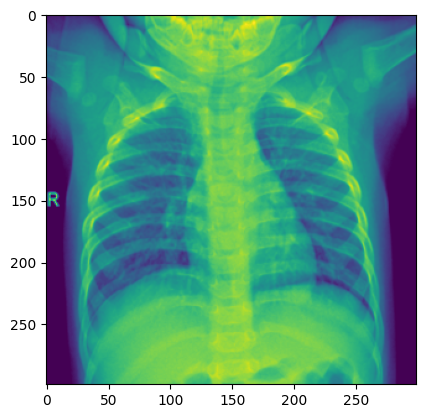

covid = 12.763513878436731%
normal = 87.23648612156327%
The predicted image is : normal


Image Name: COVID-443.png


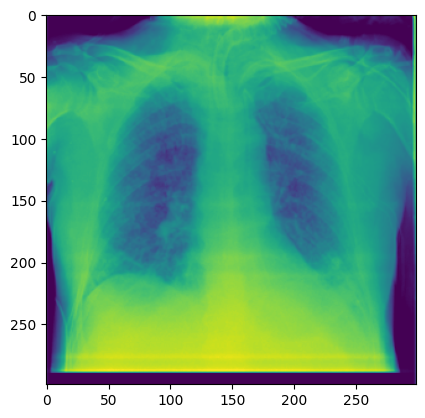

covid = 45.04922333830868%
normal = 54.95077666169132%
The predicted image is : normal


Image Name: Normal-354.png


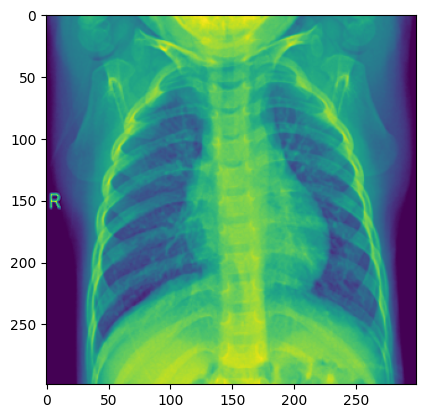

covid = 8.450049112688546%
normal = 91.54995088731145%
The predicted image is : normal


Image Name: COVID-484.png


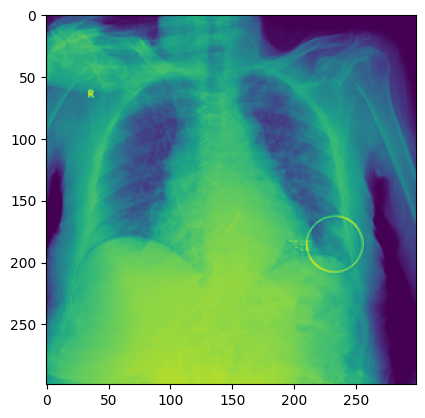

covid = 76.38132796072158%
normal = 23.61867203927844%
The predicted image is : covid


Ignored .DS_Store
Image Name: COVID-415.png


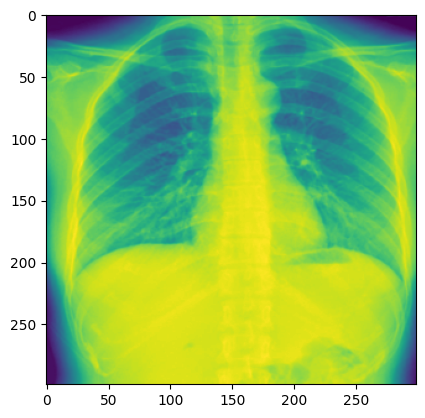

covid = 58.35373880507504%
normal = 41.646261194924975%
The predicted image is : covid


Image Name: Normal-332.png


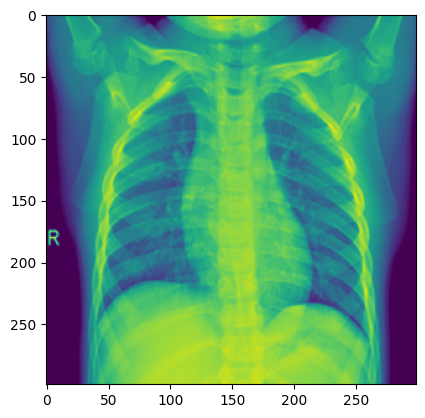

covid = 12.072219952244348%
normal = 87.92778004775568%
The predicted image is : normal




In [14]:
clf = Classifier(validation=[(x_train, y_train), (x_val, y_val)])
clf.optimize(x_train, y_train,"rf")
history = clf.train(x_train, y_train,"rf")
clf.save_model("./mlModels/rfModel.joblib")
evaluator = Evaluator(model=clf.pipeline, preprocessor=preprocessor)
# Evaluate the model
evaluator.evaluate(x_test, y_test)
# Predict the images in a directory
evaluator.predict_images_in_dir("dataset_18/testing", ['covid', 'normal'])